### **카드 유형**

cb_Visa           

cb_Mastercard         

cb_Amex            
 
cb_Discover      

In [73]:
df["card_brand"] = np.select([
    df["cb_Visa"] == 1,
    df["cb_Mastercard"] == 1,
    df["cb_Amex"] == 1,
],
[
    "visa",
    "mastercard",
    "amex",
],
    default="discover"
)

In [79]:
non = df[df["fraud"]==0].copy()

In [80]:
fraud = df[df["fraud"]==1].copy()

In [82]:
p = (
    df.groupby(["card_brand", "fraud"])
      .size()
      .groupby(level=0)
      .apply(lambda x: x / x.sum())
      .unstack()
)
p

,fraud,0,1
card_brand,card_brand,,
amex,amex,0.998331,0.001669
discover,discover,0.997818,0.002182
mastercard,mastercard,0.998532,0.001468
visa,visa,0.998670,0.001330


In [83]:
non["card_brand"].value_counts()

card_brand
mastercard    2846632
visa          1981049
amex           346838
discover       130318
Name: count, dtype: int64

In [84]:
fraud["card_brand"].value_counts()

card_brand
mastercard    4184
visa          2639
amex           580
discover       285
Name: count, dtype: int64

In [85]:
results = []

for col in ["cb_Visa",
            "cb_Mastercard",
            "cb_Amex",
            "cb_Discover"]:

    X = sm.add_constant(df[[col]].dropna())
    y = df.loc[X.index, "fraud"]

    model = sm.Logit(y, X).fit(disp=0)

    coef = model.params[col]
    pval = model.pvalues[col]
    or_val = np.exp(coef)

    results.append([col, coef, or_val, pval])

pd.DataFrame(results, columns=["feature","coef","OR","p_value"])


,feature,coef,OR,p_value
0,cb_Visa,-0.131312,0.876945,4.686713e-08
1,cb_Mastercard,0.030657,1.031132,1.809597e-01
2,cb_Amex,0.153952,1.166434,3.678975e-04
3,cb_Discover,0.424373,1.528631,2.177581e-12


In [54]:
df.infothr = df["log_abs_amount"].quantile(0.9)

df["high_amount"] = (
    df["log_abs_amount"] > thr
).astype("int8")

In [55]:
X = sm.add_constant(df[["high_amount"]].astype("float64"))
y = df["fraud"]

model = sm.Logit(y, X).fit(disp=0)

coef = model.params["high_amount"]
or_val = np.exp(coef)
pval = model.pvalues["high_amount"]

coef, or_val, pval


(np.float64(1.8733168246402847),
 np.float64(6.509852670080103),
 np.float64(0.0))

In [56]:
X = sm.add_constant(df[[
    "high_amount",
    "refund_high_amount",
    "prepaid_logamount_interaction",
    "is_highrisk_mcc",
    "card_debit(prepaid)",
    "card_debit(non_prepaid)"
]].astype("float64"))

y = df["fraud"]

model = sm.Logit(y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.009910
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                  fraud   No. Observations:              5312525
Model:                          Logit   Df Residuals:                  5312518
Method:                           MLE   Df Model:                            6
Date:                Sun, 15 Feb 2026   Pseudo R-squ.:                 0.09147
Time:                        14:38:16   Log-Likelihood:                -52648.
converged:                       True   LL-Null:                       -57948.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -7.1761      0.024   -294.099      0

# 3️⃣ User / Client-Level

👉 이 사람은 어떤 사람인가?


**프로파일 축**

yearly_income

credit_score

total_debt

credit_limit

num_credit_cards

months_from_account

years_since_pin_change

current_age

male


num_card_issued

In [9]:
df["num_cards_issued"].value_counts()

num_cards_issued
2    2684257
1    2585556
3      42898
Name: count, dtype: int64

In [25]:
p = (
    df.groupby(["fraud", "num_cards_issued"])
      .size()
      .groupby(level=0)
      .apply(lambda x: x / x.sum())
      .unstack(fill_value=0)
)

p

,num_cards_issued,1,2,3
fraud,fraud,,,
0,0,0.486670,0.50526,0.008070
1,1,0.488814,0.49974,0.011446


/home/nakyung/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


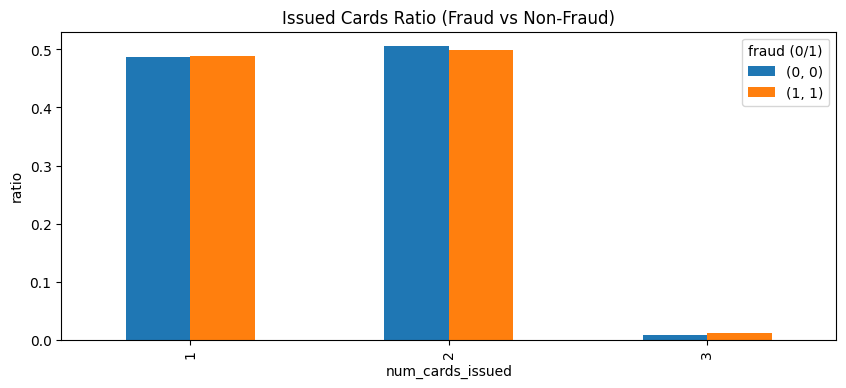

In [26]:
p = p.T
ax = p.sort_index().plot(kind="bar", figsize=(10,4))
ax.set_xlabel("num_cards_issued")
ax.set_ylabel("ratio")
ax.set_title("Issued Cards Ratio (Fraud vs Non-Fraud)")
ax.legend(title="fraud (0/1)")

num_credit_cards

In [22]:
p = (
    df.groupby(["fraud", "num_credit_cards"])
      .size()
      .groupby(level=0)
      .apply(lambda x: x / x.sum())
      .unstack(fill_value=0)
)

p

,num_credit_cards,1,2,3,4,5,6,7,8,9
fraud,fraud,,,,,,,,,
0,0,0.066878,0.126280,0.227335,0.266365,0.169337,0.090122,0.036630,0.015493,0.001561
1,1,0.039282,0.118106,0.207596,0.257024,0.189906,0.106790,0.046176,0.029787,0.005333


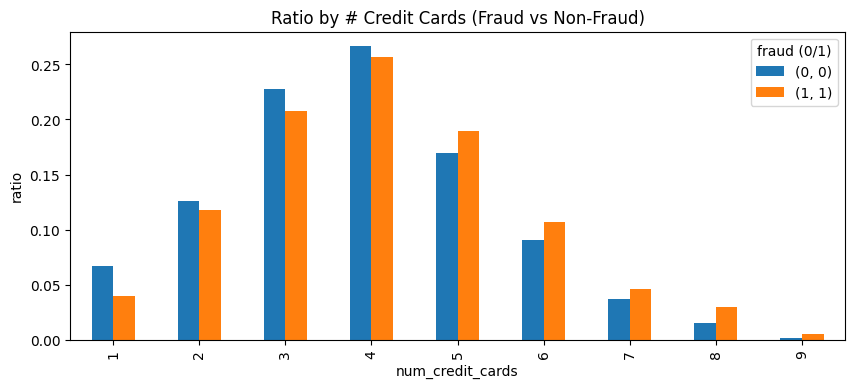

In [24]:
p = p.T
ax = p.sort_index().plot(kind="bar", figsize=(10,4))
ax.set_xlabel("num_credit_cards")
ax.set_ylabel("ratio")
ax.set_title("Ratio by # Credit Cards (Fraud vs Non-Fraud)")
ax.legend(title="fraud (0/1)")

In [28]:
df.groupby("num_credit_cards")["fraud"].agg(
    ["count", "mean"]
)

,count,mean
num_credit_cards,,
1,355089,0.000850
2,670827,0.001354
3,1207615,0.001322
4,1415048,0.001396
5,899795,0.001623
6,478920,0.001714
7,194676,0.001824
8,82419,0.002778
9,8322,0.004927


In [29]:
client = (
    df.groupby("client_id")
      .agg(
          num_cards=("num_credit_cards","max"),
          num_tx=("fraud","count"),
          fraud_rate=("fraud","mean")
      )
)
client.groupby("num_cards")["fraud_rate"].mean()


num_cards
1    0.001104
2    0.001589
3    0.002346
4    0.001714
5    0.001973
6    0.001892
7    0.002197
8    0.002906
9    0.004237
Name: fraud_rate, dtype: float64

In [30]:
X = client[["num_cards", "num_tx"]]
X = sm.add_constant(X)
y = (client["fraud_rate"] > 0).astype(int)

model = sm.Logit(y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.625521
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:             fraud_rate   No. Observations:                 1209
Model:                          Logit   Df Residuals:                     1206
Method:                           MLE   Df Model:                            2
Date:                Sat, 14 Feb 2026   Pseudo R-squ.:                 0.02247
Time:                        11:13:28   Log-Likelihood:                -756.25
converged:                       True   LL-Null:                       -773.64
Covariance Type:            nonrobust   LLR p-value:                 2.822e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3346      0.187     -1.792      0.073      -0.701       0.031
num_cards      0.2090      0.

> High-card holders 그룹에서 fraud 비중이 상대적으로 더 높아진다

In [54]:
results = []

for col in ["yearly_income",
            "credit_score",
            "total_debt",
            "credit_limit",
            "num_credit_cards"]:

    X = sm.add_constant(df[[col]].dropna())
    y = df.loc[X.index, "fraud"]

    model = sm.Logit(y, X).fit(disp=0)

    coef = model.params[col]
    pval = model.pvalues[col]
    or_val = np.exp(coef)

    results.append([col, coef, or_val, pval])

pd.DataFrame(results, columns=["feature","coef","OR","p_value"])


,feature,coef,OR,p_value
0,yearly_income,-0.000005,0.999995,7.885687e-20
1,credit_score,0.000009,1.000009,9.588085e-01
2,total_debt,-0.000002,0.999998,2.161809e-20
3,credit_limit,-0.000015,0.999985,1.079906e-42
4,num_credit_cards,0.110118,1.116410,3.760647e-54


months_from_account

In [35]:
df["months_from_account"].describe()

count    5.312525e+06
mean     6.807525e+01
std      4.576855e+01
min      0.000000e+00
25%      3.300000e+01
50%      6.100000e+01
75%      9.600000e+01
max      2.990000e+02
Name: months_from_account, dtype: float64

In [36]:
p = df[df["months_from_account"]<0]
len(p)

0

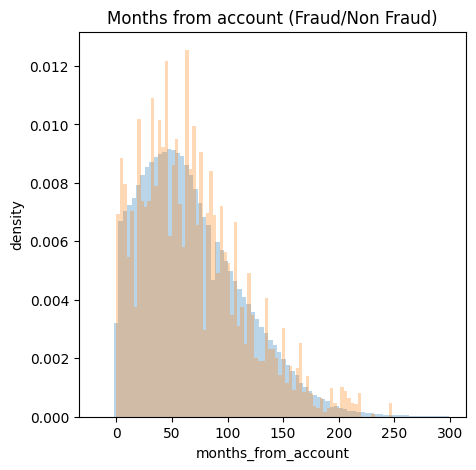

In [40]:
plt.figure(figsize=(5,5))
plt.hist(non["months_from_account"], bins=80, density=True, alpha=0.3, label="Non-Fraud")
plt.hist(fraud["months_from_account"], bins=80, density=True, alpha=0.3, label="Fraud")
plt.xlabel("months_from_account")
plt.title("Months from account (Fraud/Non Fraud)")
plt.ylabel("density")
plt.show()

years_since_pin_change

In [41]:
df["years_since_pin_change"].describe()

count    5.312525e+06
mean     2.120739e+00
std      2.216062e+00
min      0.000000e+00
25%      0.000000e+00
50%      2.000000e+00
75%      4.000000e+00
max      1.300000e+01
Name: years_since_pin_change, dtype: float64

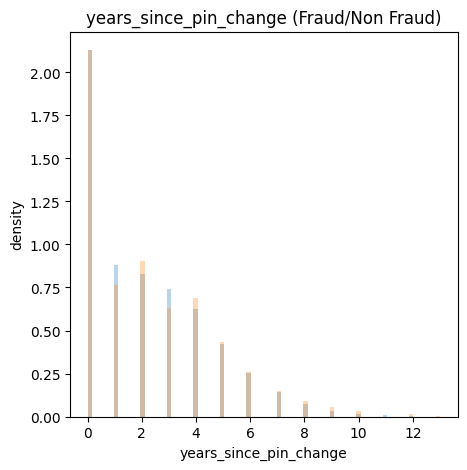

In [42]:
plt.figure(figsize=(5,5))
plt.hist(non["years_since_pin_change"], bins=80, density=True, alpha=0.3, label="Non-Fraud")
plt.hist(fraud["years_since_pin_change"], bins=80, density=True, alpha=0.3, label="Fraud")
plt.xlabel("years_since_pin_change")
plt.title("years_since_pin_change (Fraud/Non Fraud)")
plt.ylabel("density")
plt.show()

male

In [48]:
df.groupby("fraud")["male"].mean()

fraud
0    0.489206
1    0.482830
Name: male, dtype: float64

In [ ]:
results = []

for col in ["months_from_account",
            "years_since_pin_change",
            "current_age",
            "male",
            "num_credit_cards"]:

    X = sm.add_constant(df[[col]].dropna())
    y = df.loc[X.index, "fraud"]

    model = sm.Logit(y, X).fit(disp=0)

    coef = model.params[col]
    pval = model.pvalues[col]
    or_val = np.exp(coef)

    results.append([col, coef, or_val, pval])

pd.DataFrame(results, columns=["feature","coef","OR","p_value"])


,feature,coef,OR,p_value
0,months_from_account,0.000289,1.000289,2.439538e-01
1,years_since_pin_change,0.023212,1.023483,3.788355e-06
2,current_age,0.006636,1.006658,1.018238e-20
3,male,-0.025523,0.974800,2.637827e-01
4,num_credit_cards,0.110118,1.116410,3.760647e-54


In [53]:
df.drop(columns=["male", "months_from_account"], inplace=True)

---

# 4️⃣ History

### Merchant ID _ fraud 

In [ ]:
df = df.sort_values("date")

df["merchant_cum_fraud"] = (
    df.groupby("merchant_id")["fraud"]
      .cumsum()
      .shift(1)
      .fillna(0)
)

In [107]:
df["merchant_cum_tx"] = (
    df.groupby("merchant_id").cumcount()
)

df["merchant_fraud_rate"] = (
    df["merchant_cum_fraud"] /
    (df["merchant_cum_tx"] + 1)
)


In [111]:
results = []

for col in ["merchant_fraud_rate", "merchant_cum_fraud"]:

    X = sm.add_constant(df[[col]].dropna())
    y = df.loc[X.index, "fraud"]

    model = sm.Logit(y, X).fit(disp=0)

    coef = model.params[col]
    pval = model.pvalues[col]
    or_val = np.exp(coef)

    results.append([col, coef, or_val, pval])

pd.DataFrame(results, columns=["feature","coef","OR","p_value"])

,feature,coef,OR,p_value
0,merchant_fraud_rate,0.007414,1.007442,1.698145e-33
1,merchant_cum_fraud,0.000052,1.000052,7.772519e-01


In [ ]:
X = sm.add_constant(df[["merchant_fraud_rate", "merchant_cum_fraud"]].dropna())
y = df["fraud"]

model = sm.Logit(y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.010901
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                  fraud   No. Observations:              5312525
Model:                          Logit   Df Residuals:                  5312522
Method:                           MLE   Df Model:                            2
Date:                Sun, 15 Feb 2026   Pseudo R-squ.:               0.0006353
Time:                        15:10:06   Log-Likelihood:                -57911.
converged:                       True   LL-Null:                       -57948.
Covariance Type:            nonrobust   LLR p-value:                 1.025e-16
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -6.5366      0.012   -548.296      0.000      -6.560      -6.513
m

> 통계적으로는 유의미하지만
> 효과 크기는 거의 없음.

In [113]:
df.groupby("merchant_id")["fraud"].sum().describe()

count    53596.000000
mean         0.143444
std          4.249446
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        571.000000
Name: fraud, dtype: float64

### 누적 error

In [87]:
# 한 client id당 error 누적 횟수 _ 현재 행 제외
df["client_error_cum_prev"] = (
    df.groupby("client_id")["has_error"]
      .cumsum()
      .shift(1)
      .fillna(0)
      .astype("int32")
)

In [25]:
df["client_error_cum_prev"].value_counts()

client_error_cum_prev
0       91853
3       90871
13      88175
15      87766
2       87024
4       86607
20      86122
6       85587
8       85410
5       85378
12      85271
10      85223
23      85027
1       83709
11      83449
14      82635
21      82601
9       81564
16      81141
17      81013
19      80085
27      79771
18      79608
25      79565
24      79448
22      78585
28      78099
7       77840
29      76449
26      74132
31      71893
33      70725
32      68780
34      68764
30      67664
36      65995
37      63996
38      62849
35      62359
39      60388
41      57215
43      57118
40      57059
42      55786
44      53237
45      52080
47      48697
48      47927
46      46567
50      43536
52      43072
49      42811
54      41973
55      40679
53      39937
51      39929
56      38306
57      37649
58      33813
61      33401
59      32829
60      30842
65      29672
63      29059
62      28473
66      28107
64      27808
68      27301
67      26983
69      2605

In [78]:
# 한 card id당 error 누적 횟수 _ 현재 행 제외
df["card_error_cum_prev"] = (
    df.groupby("card_id")["has_error"]
      .cumsum()
      .shift(1)
      .fillna(0)
      .astype("int32")
)

df["card_error_cum_prev"].value_counts()

card_error_cum_prev
0      271769
1      259167
2      247796
3      243696
4      236827
5      220159
6      214474
7      201794
8      194251
9      180379
10     171987
11     161841
12     149229
13     142216
14     136644
15     129244
16     114103
17     107826
18     101192
19      94106
20      91111
21      85204
22      80545
23      74506
24      70477
25      64790
26      63097
27      60064
28      52553
29      49615
31      47256
30      44777
32      42107
34      38060
33      37994
36      37221
35      35004
38      34862
37      33918
39      31084
40      28130
41      24522
43      23582
42      22931
44      22626
45      20856
47      18869
46      18803
48      18449
49      16988
51      15804
50      15717
52      15124
53      14091
54      14090
57      13034
55      11742
56      11600
58      11120
59      10323
65       9207
61       8987
63       8414
60       8123
62       7913
70       7895
64       7644
67       7286
66       7070
71       6837


In [79]:
df["client_error_last5"] = (
    df.groupby("client_id")["has_error"]
      .rolling(5, min_periods=1)
      .sum()
      .reset_index(level=0, drop=True)
      .shift(1)
      .fillna(0)
)

df["client_error_last5"].value_counts()

client_error_last5
0.0    4915129
1.0     373354
2.0      22859
3.0       1124
4.0         58
5.0          1
Name: count, dtype: int64

In [80]:
df["client_error_last3"] = (
    df.groupby("client_id")["has_error"]
      .rolling(3, min_periods=1)
      .sum()
      .reset_index(level=0, drop=True)
      .shift(1)
      .fillna(0)
)

df["client_error_last3"].value_counts()

client_error_last3
0.0    5068340
1.0     234895
2.0       9102
3.0        188
Name: count, dtype: int64

In [81]:
df["client_error_last1"] = (
    df.groupby("client_id")["has_error"]
      .rolling(1, min_periods=1)
      .sum()
      .reset_index(level=0, drop=True)
      .shift(1)
      .fillna(0)
)

df["client_error_last1"].value_counts()

client_error_last1
0.0    5227955
1.0      84570
Name: count, dtype: int64

In [82]:
g = df.groupby("card_id")["has_error"]

df["card_error_last5"] = (
    g.shift(1).fillna(0)
  + g.shift(2).fillna(0)
  + g.shift(3).fillna(0)
  + g.shift(4).fillna(0)
  + g.shift(5).fillna(0)
).astype("int8")


df["card_error_last5"].value_counts()

card_error_last5
0    4914378
1     375436
2      21576
3       1081
4         54
Name: count, dtype: int64

In [83]:
g = df.groupby("card_id")["has_error"]

df["card_error_last3"] = (
    g.shift(1).fillna(0)
  + g.shift(2).fillna(0)
  + g.shift(3).fillna(0)
).astype("int8")


df["card_error_last3"].value_counts()

card_error_last3
0    5067868
1     236088
2       8396
3        173
Name: count, dtype: int64

In [84]:
g = df.groupby("card_id")["has_error"]

df["card_error_last1"] = (
    g.shift(1).fillna(0)
).astype("int8")


df["card_error_last1"].value_counts()

card_error_last1
0    5228007
1      84518
Name: count, dtype: int64

In [88]:
results = []

for col in ["client_error_cum_prev",
            "client_error_last5",
            "client_error_last3",
            "client_error_last1"]:

    X = sm.add_constant(df[[col]].dropna())
    y = df.loc[X.index, "fraud"]

    model = sm.Logit(y, X).fit(disp=0)

    coef = model.params[col]
    pval = model.pvalues[col]
    or_val = np.exp(coef)

    results.append([col, coef, or_val, pval])

pd.DataFrame(results, columns=["feature","coef","OR","p_value"])

,feature,coef,OR,p_value
0,client_error_cum_prev,-0.000030,0.999970,8.791908e-01
1,client_error_last5,0.379912,1.462156,2.249386e-32
2,client_error_last3,0.449475,1.567489,1.661419e-28
3,client_error_last1,0.527811,1.695218,9.568197e-14


In [89]:
results = []

for col in ["card_error_cum_prev",
            "card_error_last5",
            "card_error_last3",
            "card_error_last1"]:

    X = sm.add_constant(df[[col]].dropna())
    y = df.loc[X.index, "fraud"]

    model = sm.Logit(y, X).fit(disp=0)

    coef = model.params[col]
    pval = model.pvalues[col]
    or_val = np.exp(coef)

    results.append([col, coef, or_val, pval])

pd.DataFrame(results, columns=["feature","coef","OR","p_value"])

,feature,coef,OR,p_value
0,card_error_cum_prev,-0.000375,0.999625,3.257898e-01
1,card_error_last5,0.536283,1.709640,1.730205e-73
2,card_error_last3,0.635708,1.888359,3.693278e-66
3,card_error_last1,0.725138,2.065016,3.343331e-29


In [92]:
X = sm.add_constant(df[["client_error_cum_prev",
            "client_error_last5",
            "client_error_last3",
            "client_error_last1",
            "card_error_cum_prev",
            "card_error_last5",
            "card_error_last3",
            "card_error_last1"]].dropna())
y = df["fraud"]

model = sm.Logit(y, X).fit()
print(model.summary())


Optimization terminated successfully.
         Current function value: 0.010880
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                  fraud   No. Observations:              5312525
Model:                          Logit   Df Residuals:                  5312516
Method:                           MLE   Df Model:                            8
Date:                Sun, 15 Feb 2026   Pseudo R-squ.:                0.002519
Time:                        15:00:27   Log-Likelihood:                -57802.
converged:                       True   LL-Null:                       -57948.
Covariance Type:            nonrobust   LLR p-value:                 2.139e-58
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -6.5922      0.015   -432.124      0.000      -6.622      -6

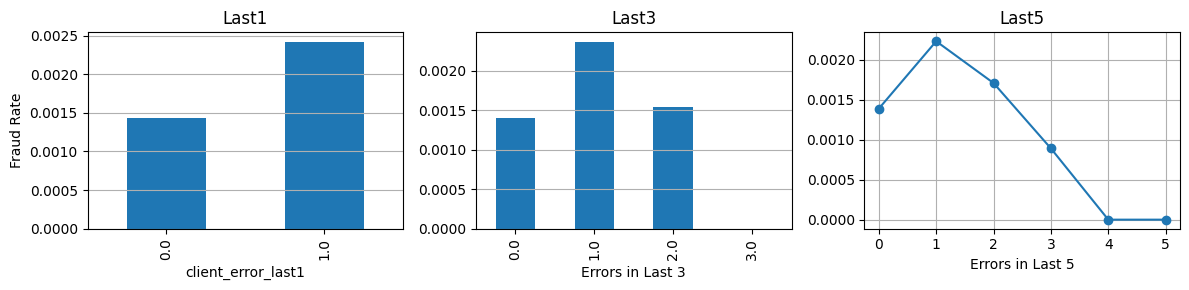

In [35]:
# fraud rate 계산
rate_last1 = df.groupby("client_error_last1")["fraud"].mean()
rate_last3 = df.groupby("client_error_last3")["fraud"].mean()
rate_last5 = df.groupby("client_error_last5")["fraud"].mean()

fig, axes = plt.subplots(1, 3, figsize=(12, 3))

rate_last1.plot(kind="bar", ax=axes[0])
axes[0].set_title("Last1")
axes[0].set_xlabel("client_error_last1")
axes[0].set_ylabel("Fraud Rate")
axes[0].grid(axis="y")

rate_last3.plot(kind="bar", ax=axes[1])
axes[1].set_title("Last3")
axes[1].set_xlabel("Errors in Last 3")
axes[1].grid(axis="y")

axes[2].plot(rate_last5.index, rate_last5.values, marker="o")
axes[2].set_title("Last5")
axes[2].set_xlabel("Errors in Last 5")
axes[2].grid(True)

plt.tight_layout()
plt.show()


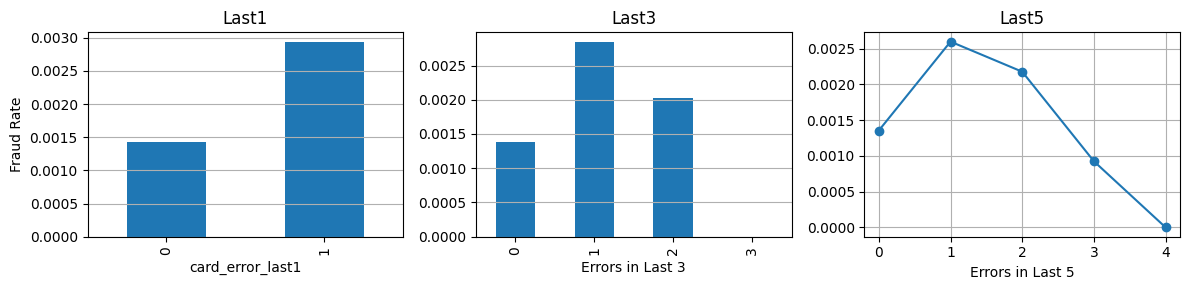

In [36]:
rate_last1 = df.groupby("card_error_last1")["fraud"].mean()
rate_last3 = df.groupby("card_error_last3")["fraud"].mean()
rate_last5 = df.groupby("card_error_last5")["fraud"].mean()

fig, axes = plt.subplots(1, 3, figsize=(12, 3))

rate_last1.plot(kind="bar", ax=axes[0])
axes[0].set_title("Last1")
axes[0].set_xlabel("card_error_last1")
axes[0].set_ylabel("Fraud Rate")
axes[0].grid(axis="y")

rate_last3.plot(kind="bar", ax=axes[1])
axes[1].set_title("Last3")
axes[1].set_xlabel("Errors in Last 3")
axes[1].grid(axis="y")

axes[2].plot(rate_last5.index, rate_last5.values, marker="o")
axes[2].set_title("Last5")
axes[2].set_xlabel("Errors in Last 5")
axes[2].grid(True)

plt.tight_layout()
plt.show()


신호 안정성 확인

In [37]:
col = [
    "client_error_last1",
    "client_error_last3",
    "client_error_last5",
    "card_error_last1",
    "card_error_last3",
    "card_error_last5",
]

for c in col:
    table = (
        df.groupby(["tx_year", c])["fraud"]
          .mean()
          .unstack()
          .round(4)
    )
    
    print(f"\n===== {c} =====")
    display(table)



===== client_error_last1 =====


client_error_last1,0.0,1.0
tx_year,,
2010,0.0031,0.0058
2011,0.0000,0.0001
2012,0.0010,0.0010
2013,0.0014,0.0028
2014,0.0007,0.0014
2015,0.0023,0.0035



===== client_error_last3 =====


client_error_last3,0.0,1.0,2.0,3.0
tx_year,,,,
2010,0.0030,0.0053,0.0050,0.0
2011,0.0000,0.0002,0.0000,0.0
2012,0.0010,0.0012,0.0014,0.0
2013,0.0014,0.0026,0.0019,0.0
2014,0.0007,0.0014,0.0000,0.0
2015,0.0023,0.0036,0.0013,0.0



===== client_error_last5 =====


client_error_last5,0.0,1.0,2.0,3.0,4.0,5.0
tx_year,,,,,,
2010,0.0030,0.0047,0.0053,0.0077,0.0,NaN
2011,0.0000,0.0001,0.0000,0.0000,0.0,NaN
2012,0.0010,0.0013,0.0008,0.0000,0.0,NaN
2013,0.0014,0.0024,0.0017,0.0000,0.0,NaN
2014,0.0007,0.0014,0.0000,0.0000,0.0,0.0
2015,0.0023,0.0035,0.0025,0.0000,0.0,NaN



===== card_error_last1 =====


card_error_last1,0,1
tx_year,,
2010,0.0030,0.0065
2011,0.0000,0.0002
2012,0.0010,0.0017
2013,0.0014,0.0034
2014,0.0007,0.0015
2015,0.0023,0.0044



===== card_error_last3 =====


card_error_last3,0,1,2,3
tx_year,,,,
2010,0.0030,0.0060,0.0049,0.0
2011,0.0000,0.0002,0.0000,0.0
2012,0.0010,0.0019,0.0008,0.0
2013,0.0014,0.0032,0.0020,0.0
2014,0.0007,0.0017,0.0000,0.0
2015,0.0023,0.0041,0.0047,0.0



===== card_error_last5 =====


card_error_last5,0,1,2,3,4
tx_year,,,,,
2010,0.0029,0.0054,0.0055,0.0083,0.0
2011,0.0000,0.0002,0.0000,0.0000,0.0
2012,0.0010,0.0018,0.0018,0.0000,0.0
2013,0.0013,0.0031,0.0016,0.0000,0.0
2014,0.0007,0.0016,0.0000,0.0000,0.0
2015,0.0022,0.0037,0.0045,0.0000,0.0


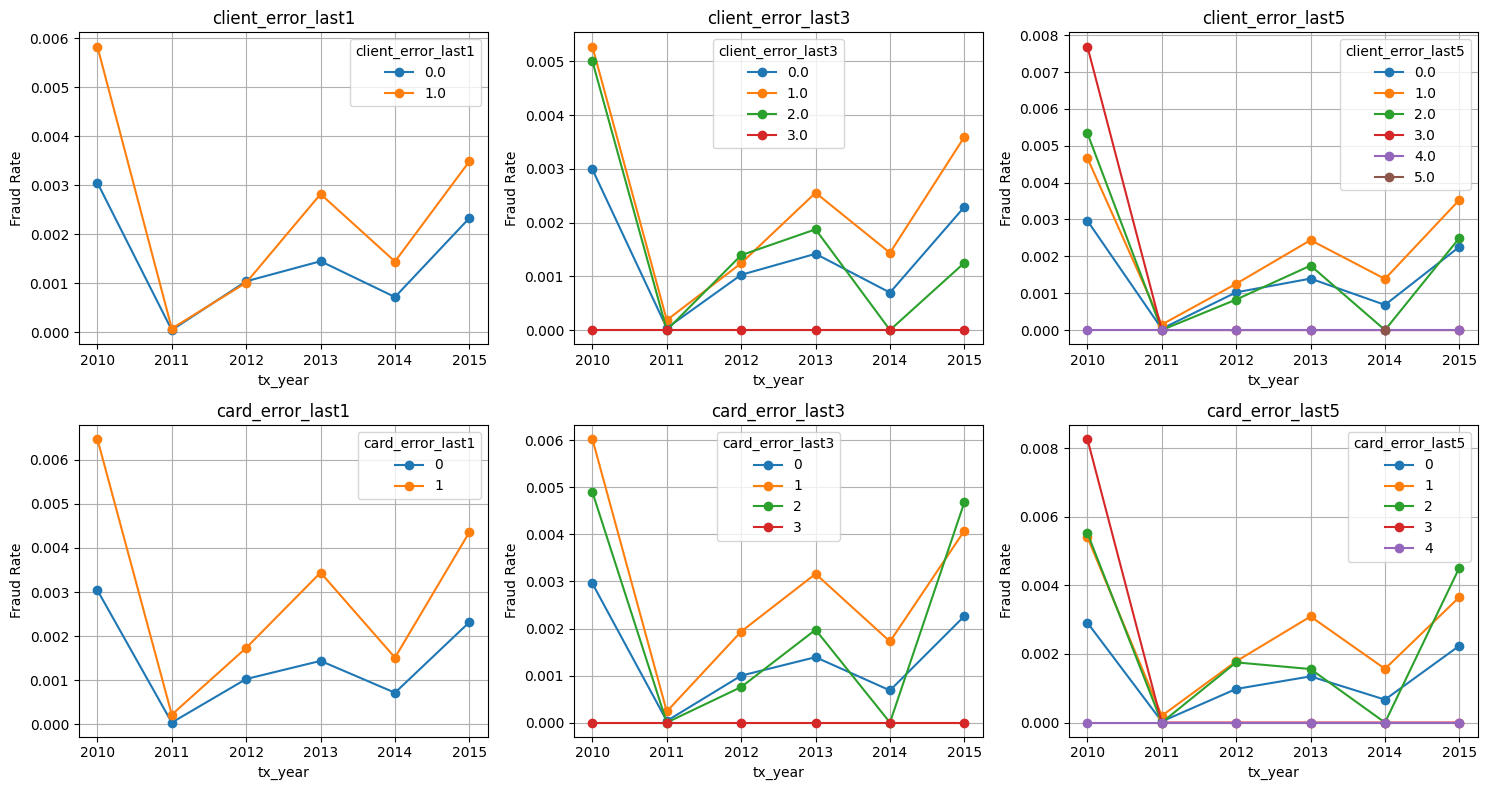

In [38]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, c in enumerate(col):
    pivot = (
        df.groupby(["tx_year", c])["fraud"]
          .mean()
          .unstack()
    )
    
    pivot.plot(ax=axes[i], marker="o")
    axes[i].set_title(c)
    axes[i].set_ylabel("Fraud Rate")
    axes[i].grid(True)

plt.tight_layout()
plt.show()


In [39]:
cols = [
    "client_error_last1",
    "client_error_last3",
    "card_error_last1",
    "card_error_last3",
]

result = []

for c in cols:
    for year in sorted(df["tx_year"].unique()):
        sub = df[df["tx_year"] == year]
        
        base = sub[sub[c] == 0]["fraud"].mean()
        burst = sub[sub[c] >= 1]["fraud"].mean()
        
        uplift = burst / base if base > 0 else None
        
        result.append({
            "feature": c,
            "tx_year": year,
            "uplift": round(uplift, 2) if uplift else None
        })

uplift_all = pd.DataFrame(result)
display(uplift_all.pivot(index="tx_year", columns="feature", values="uplift"))


feature,card_error_last1,card_error_last3,client_error_last1,client_error_last3
tx_year,,,,
2010,2.13,2.03,1.91,1.76
2011,5.46,6.65,1.72,4.84
2012,1.69,1.90,0.97,1.21
2013,2.39,2.24,1.95,1.78
2014,2.11,2.43,2.01,1.98
2015,1.88,1.81,1.50,1.53


### Amount 기반 이탈도

In [41]:
df["client_avg_amount_prev"] = (
    df.groupby("client_id")["amount"]
      .expanding()
      .mean()
      .shift(1)
      .reset_index(level=0, drop=True)
)

In [ ]:
df["amount_vs_client_avg_ratio"] = (
    df["amount"] / df["client_avg_amount_prev"]
)

In [43]:
df["amount_vs_client_avg_diff"] = (
    df["amount"] - df["client_avg_amount_prev"]
)

### MCC 기반 행동 이탈

In [49]:
df = df.sort_values(["client_id", "date"]).copy()
df["mcc"] = df["mcc"].astype("category")

In [93]:
g = df.groupby("client_id")["mcc"]

df["client_mcc_prev"] = g.shift(1)
df["client_mcc_match_last1"] = (df["mcc"] == df["client_mcc_prev"]).fillna(False).astype("int8")

In [94]:
# 최근 3/5거래에서 현재 mcc가 등장했는지 
m1 = (df["mcc"] == g.shift(1))
m2 = (df["mcc"] == g.shift(2))
m3 = (df["mcc"] == g.shift(3))
m4 = (df["mcc"] == g.shift(4))
m5 = (df["mcc"] == g.shift(5))

df["client_mcc_seen_last3"] = (m1 | m2 | m3).fillna(False).astype("int8")
df["client_mcc_seen_last5"] = (m1 | m2 | m3 | m4 | m5).fillna(False).astype("int8")

# 최근 3/5거래에서 '현재 mcc'가 몇 번 반복됐는지 (0~3 / 0~5)
df["client_mcc_repeat_cnt_last3"] = (m1.fillna(False).astype("int8")
                                   + m2.fillna(False).astype("int8")
                                   + m3.fillna(False).astype("int8"))

df["client_mcc_repeat_cnt_last5"] = (m1.fillna(False).astype("int8")
                                   + m2.fillna(False).astype("int8")
                                   + m3.fillna(False).astype("int8")
                                   + m4.fillna(False).astype("int8")
                                   + m5.fillna(False).astype("int8"))

# 비율 버전 (0~1)
df["client_mcc_repeat_ratio_last3"] = (df["client_mcc_repeat_cnt_last3"] / 3).astype("float32")
df["client_mcc_repeat_ratio_last5"] = (df["client_mcc_repeat_cnt_last5"] / 5).astype("float32")


In [128]:
df["client_mcc_prior_count"] = df.groupby(["client_id", "mcc"]).cumcount()
# 과거에 없었다 = 첫 등장(현재 포함) → 과거 기준으로는 "신규"가 맞음
df["client_mcc_is_new"] = (df["client_mcc_prior_count"] == 0).astype("int8")


In [96]:
prev = g.shift(1)
prev2 = g.shift(2)
prev3 = g.shift(3)
prev4 = g.shift(4)
prev5 = g.shift(5)

# 최근 5개에서 "바뀐 횟수" (근사 다양성)
# (prev5->prev4, prev4->prev3, prev3->prev2, prev2->prev1) 중 바뀐 횟수
chg1 = (prev  != prev2)
chg2 = (prev2 != prev3)
chg3 = (prev3 != prev4)
chg4 = (prev4 != prev5)

df["client_mcc_change_cnt_last5"] = (chg1.fillna(False).astype("int8")
                                  + chg2.fillna(False).astype("int8")
                                  + chg3.fillna(False).astype("int8")
                                  + chg4.fillna(False).astype("int8"))


In [97]:
g = df.groupby("card_id")["mcc"]

df["card_mcc_prev"] = g.shift(1)
df["card_mcc_match_last1"] = (df["mcc"] == df["card_mcc_prev"]).fillna(False).astype("int8")

In [98]:
# 최근 3/5거래에서 현재 mcc가 등장했는지 
m1 = (df["mcc"] == g.shift(1))
m2 = (df["mcc"] == g.shift(2))
m3 = (df["mcc"] == g.shift(3))
m4 = (df["mcc"] == g.shift(4))
m5 = (df["mcc"] == g.shift(5))

df["card_mcc_seen_last3"] = (m1 | m2 | m3).fillna(False).astype("int8")
df["card_mcc_seen_last5"] = (m1 | m2 | m3 | m4 | m5).fillna(False).astype("int8")

# 최근 3/5거래에서 '현재 mcc'가 몇 번 반복됐는지 (0~3 / 0~5)
df["card_mcc_repeat_cnt_last3"] = (m1.fillna(False).astype("int8")
                                   + m2.fillna(False).astype("int8")
                                   + m3.fillna(False).astype("int8"))

df["card_mcc_repeat_cnt_last5"] = (m1.fillna(False).astype("int8")
                                   + m2.fillna(False).astype("int8")
                                   + m3.fillna(False).astype("int8")
                                   + m4.fillna(False).astype("int8")
                                   + m5.fillna(False).astype("int8"))

# 비율 버전 (0~1)
df["card_mcc_repeat_ratio_last3"] = (df["card_mcc_repeat_cnt_last3"] / 3).astype("float32")
df["card_mcc_repeat_ratio_last5"] = (df["card_mcc_repeat_cnt_last5"] / 5).astype("float32")


In [99]:
df["card_mcc_prior_count"] = df.groupby(["client_id", "mcc"]).cumcount()
# 과거에 없었다 = 첫 등장(현재 포함) → 과거 기준으로는 "신규"가 맞음
df["card_mcc_is_new"] = (df["card_mcc_prior_count"] == 0).astype("int8")


In [100]:
prev = g.shift(1)
prev2 = g.shift(2)
prev3 = g.shift(3)
prev4 = g.shift(4)
prev5 = g.shift(5)

# 최근 5개에서 "바뀐 횟수" (근사 다양성)
# (prev5->prev4, prev4->prev3, prev3->prev2, prev2->prev1) 중 바뀐 횟수
chg1 = (prev  != prev2)
chg2 = (prev2 != prev3)
chg3 = (prev3 != prev4)
chg4 = (prev4 != prev5)

df["card_mcc_change_cnt_last5"] = (chg1.fillna(False).astype("int8")
                                  + chg2.fillna(False).astype("int8")
                                  + chg3.fillna(False).astype("int8")
                                  + chg4.fillna(False).astype("int8"))


In [58]:
def analyze_feature(df, feature):
    
    # Fraud rate 테이블
    table = (
        df.groupby(feature)["fraud"]
          .agg(["mean", "count"])
          .rename(columns={"mean": "fraud_rate"})
    )
    
    # baseline 계산
    baseline = table["fraud_rate"].min()
    table["uplift"] = table["fraud_rate"] / baseline
    
    display(table.round(4))
    
    # 시각화
    plt.figure(figsize=(5,4))
    table["fraud_rate"].plot(kind="bar")
    plt.title(f"{feature} vs Fraud Rate")
    plt.ylabel("Fraud Rate")
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()


In [101]:
mcc_features = [
    "client_mcc_match_last1",
    "client_mcc_seen_last3",
    "client_mcc_seen_last5",
    "client_mcc_repeat_cnt_last3",
    "client_mcc_repeat_cnt_last5",
    "client_mcc_is_new",
    "client_mcc_change_cnt_last5",
    
    "card_mcc_match_last1",
    "card_mcc_seen_last3",
    "card_mcc_seen_last5",
    "card_mcc_repeat_cnt_last3",
    "card_mcc_repeat_cnt_last5",
    "card_mcc_is_new",
    "card_mcc_change_cnt_last5",
]


========== client_mcc_match_last1 ==========


,fraud_rate,count,uplift
client_mcc_match_last1,,,
0,0.0017,4324583,2.9533
1,0.0006,987942,1.0000


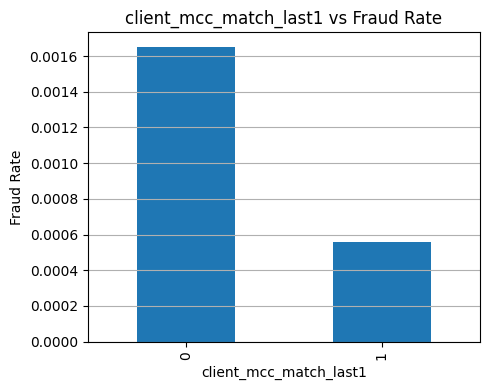


========== client_mcc_seen_last3 ==========


,fraud_rate,count,uplift
client_mcc_seen_last3,,,
0,0.0019,3549924,3.0282
1,0.0006,1762601,1.0000


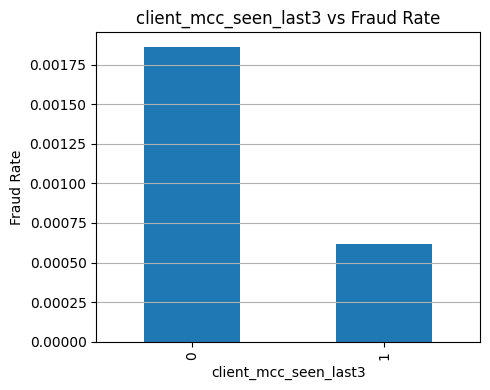


========== client_mcc_seen_last5 ==========


,fraud_rate,count,uplift
client_mcc_seen_last5,,,
0,0.0021,3004378,3.2011
1,0.0006,2308147,1.0000


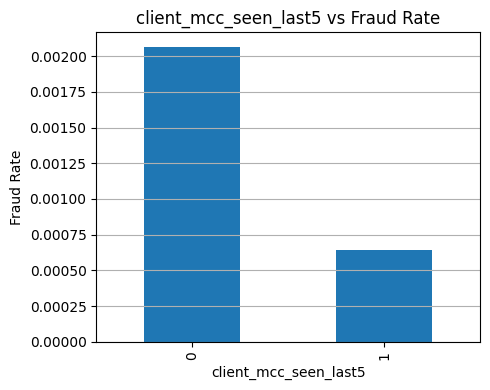


========== client_mcc_repeat_cnt_last3 ==========


,fraud_rate,count,uplift
client_mcc_repeat_cnt_last3,,,
0,0.0019,3549924,98.1524
1,0.0008,1230512,42.8708
2,0.0002,426583,10.0168
3,0.0000,105506,1.0000


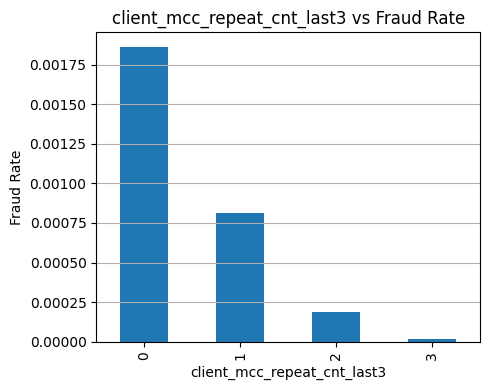


========== client_mcc_repeat_cnt_last5 ==========


,fraud_rate,count,uplift
client_mcc_repeat_cnt_last5,,,
0,0.0021,3004378,inf
1,0.0010,1330947,inf
2,0.0003,603778,inf
3,0.0001,251055,inf
4,0.0000,96853,NaN
5,0.0000,25514,NaN


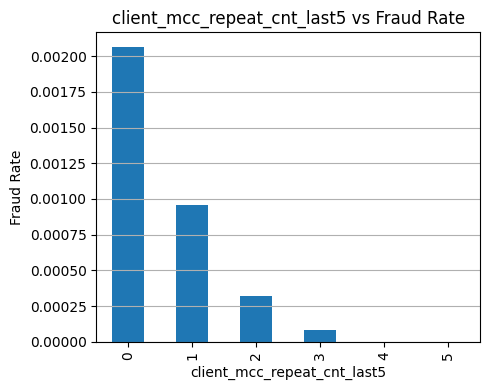


========== client_mcc_is_new ==========


,fraud_rate,count,uplift
client_mcc_is_new,,,
0,0.0011,5232397,1.0000
1,0.0234,80128,21.0183


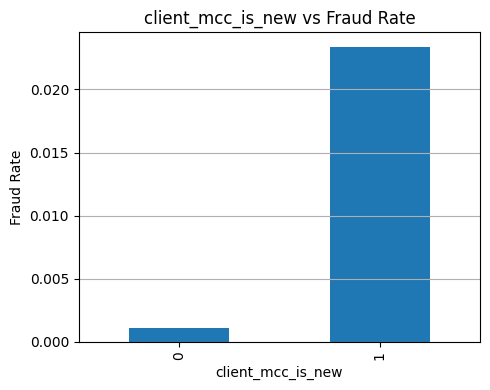


========== client_mcc_change_cnt_last5 ==========


,fraud_rate,count,uplift
client_mcc_change_cnt_last5,,,
0,0.0004,50710,1.0000
1,0.0006,173947,1.5548
2,0.0008,747281,2.2544
3,0.0012,1730478,3.2527
4,0.0019,2610109,5.3730


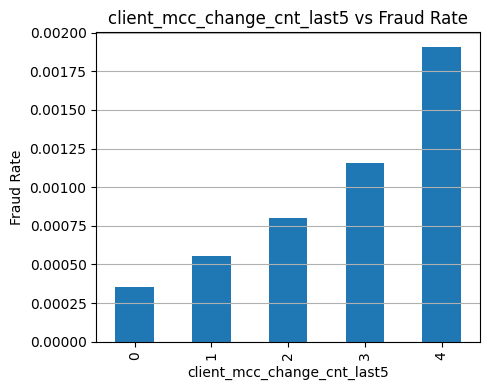


========== card_mcc_match_last1 ==========


,fraud_rate,count,uplift
card_mcc_match_last1,,,
0,0.0016,4298381,2.7231
1,0.0006,1014144,1.0000


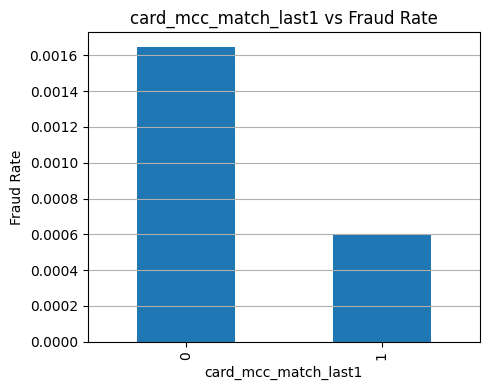


========== card_mcc_seen_last3 ==========


,fraud_rate,count,uplift
card_mcc_seen_last3,,,
0,0.0019,3500913,2.7731
1,0.0007,1811612,1.0000


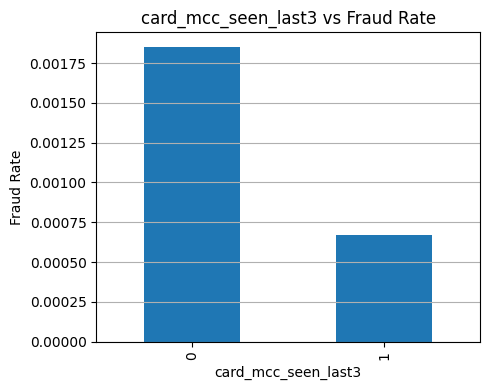


========== card_mcc_seen_last5 ==========


,fraud_rate,count,uplift
card_mcc_seen_last5,,,
0,0.0020,2976912,2.9273
1,0.0007,2335613,1.0000


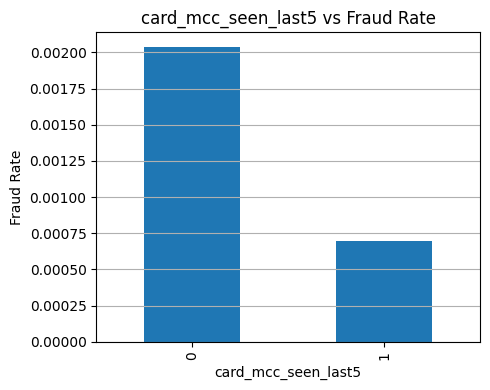


========== card_mcc_repeat_cnt_last3 ==========


,fraud_rate,count,uplift
card_mcc_repeat_cnt_last3,,,
0,0.0019,3500913,55.5448
1,0.0009,1237765,26.5275
2,0.0002,453793,7.3414
3,0.0000,120054,1.0000


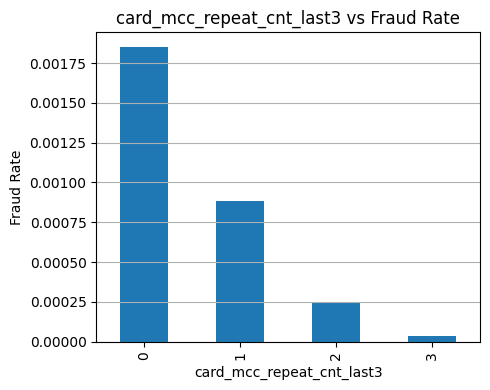


========== card_mcc_repeat_cnt_last5 ==========


,fraud_rate,count,uplift
card_mcc_repeat_cnt_last5,,,
0,0.0020,2976912,inf
1,0.0010,1316970,inf
2,0.0004,613397,inf
3,0.0001,263778,inf
4,0.0000,110339,inf
5,0.0000,31129,NaN


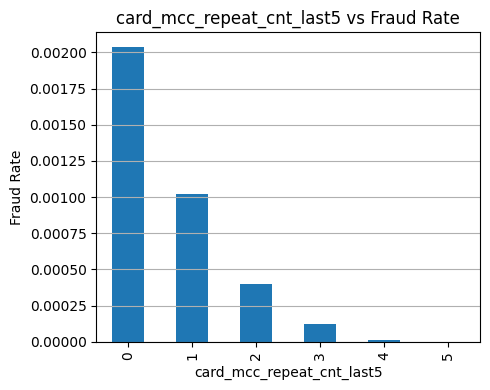


========== card_mcc_is_new ==========


,fraud_rate,count,uplift
card_mcc_is_new,,,
0,0.0011,5232397,1.0000
1,0.0234,80128,21.0183


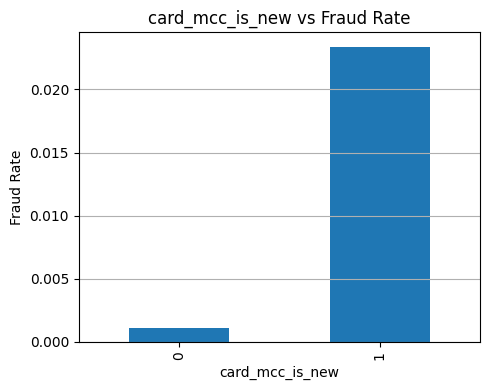


========== card_mcc_change_cnt_last5 ==========


,fraud_rate,count,uplift
card_mcc_change_cnt_last5,,,
0,0.0002,59740,1.0000
1,0.0004,188335,1.6313
2,0.0007,767735,3.1014
3,0.0011,1710435,4.7525
4,0.0020,2586280,8.4789


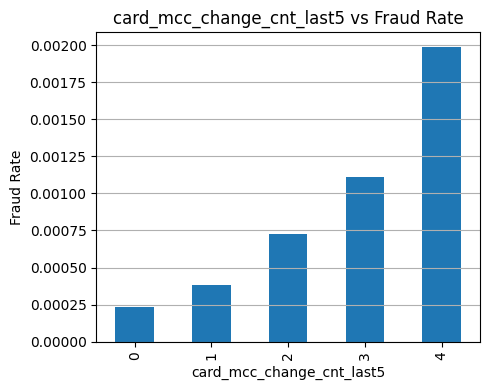

In [ ]:
for f in mcc_features:
    print(f"\n========== {f} ==========")
    analyze_feature(df, f)


In [61]:
results = []

for col in mcc_features:

    X = sm.add_constant(df[[col]].dropna())
    y = df.loc[X.index, "fraud"]

    model = sm.Logit(y, X).fit(disp=0)

    coef = model.params[col]
    pval = model.pvalues[col]
    or_val = np.exp(coef)

    results.append([col, coef, or_val, pval])

pd.DataFrame(results, columns=["feature","coef","OR","p_value"])


,feature,coef,OR,p_value
0,client_mcc_match_last1,-1.084005,0.338238,7.213076e-133
1,client_mcc_seen_last3,-1.109204,0.329821,9.759114e-251
2,client_mcc_seen_last5,-1.164912,0.311950,0.000000e+00
3,client_mcc_repeat_cnt_last3,-0.950357,0.386603,5.867734e-257
4,client_mcc_repeat_cnt_last5,-0.883468,0.413347,0.000000e+00
5,client_mcc_is_new,3.067922,21.497180,0.000000e+00
6,client_mcc_change_cnt_last5,0.449570,1.567639,3.093055e-167
7,card_mcc_match_last1,-1.002807,0.366848,2.647220e-125
8,card_mcc_seen_last3,-1.021151,0.360180,7.614464e-233
9,card_mcc_seen_last5,-1.075428,0.341152,0.000000e+00


In [102]:
X = sm.add_constant(df[[mcc_features]].dropna())
y = df["fraud"]

model = sm.Logit(y, X).fit()
print(model.summary())

KeyError: "None of [Index([('client_mcc_match_last1', 'client_mcc_seen_last3', 'client_mcc_seen_last5', 'client_mcc_repeat_cnt_last3', 'client_mcc_repeat_cnt_last5', 'client_mcc_is_new', 'client_mcc_change_cnt_last5', 'card_mcc_match_last1', 'card_mcc_seen_last3', 'card_mcc_seen_last5', 'card_mcc_repeat_cnt_last3', 'card_mcc_repeat_cnt_last5', 'card_mcc_is_new', 'card_mcc_change_cnt_last5')], dtype='object')] are in the [columns]"

In [62]:
df[df["client_mcc_is_new"]==1]["mcc"].value_counts().head(10)


mcc
5311    1208
5300    1207
5541    1207
5310    1206
5411    1206
5912    1206
5211    1203
5499    1200
7230    1200
5942    1200
Name: count, dtype: int64

In [63]:
df.groupby("mcc")["fraud"].mean().sort_values(ascending=False).head(10)

/tmp/ipykernel_3743864/79550822.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("mcc")["fraud"].mean().sort_values(ascending=False).head(10)


mcc
4411    0.658163
5733    0.395522
3006    0.140000
5732    0.107561
3144    0.090164
3005    0.085890
5045    0.083486
3009    0.076389
3007    0.069182
5816    0.066492
Name: fraud, dtype: float64

신규 MCC 효과 = 단순히 “원래 위험한 업종이라서”는 아님.

In [66]:
df["amount"].max()

np.float32(5696.78)

In [64]:
df[df["client_mcc_is_new"]==1]["amount"].describe()

count    80128.000000
mean       177.812225
std        274.712952
min       -500.000000
25%         27.200001
50%         88.105000
75%        239.622501
max       5696.779785
Name: amount, dtype: float64

In [65]:
df[df["client_mcc_is_new"]==1]["card_error_last1"].mean()

np.float64(0.012654752396166135)

신규 MCC 신호는 error와 완전히 종속된 건 아니다.

### 시간대, frequency 기반 이탈

In [3]:
df["hour_sin"] = np.sin(2 * np.pi * df["tx_hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["tx_hour"] / 24)

In [5]:
df["hour_deviation"] = np.sqrt(
    (df["hour_sin"] - df["client_hour_sin_avg"])**2 +
    (df["hour_cos"] - df["client_hour_cos_avg"])**2
)

In [6]:
df["hour_deviation"].describe()

count    5.312524e+06
mean     8.089620e-01
std      3.073395e-01
min      0.000000e+00
25%      5.729767e-01
50%      7.869112e-01
75%      1.016422e+00
max      2.000000e+00
Name: hour_deviation, dtype: float64

In [8]:
g = df.groupby("client_id")["weekday"]

df["client_weekday_prev"] = g.shift(1)
df["client_weekday_match_last1"] = (
    df["weekday"] == df["client_weekday_prev"]
).astype("int8")

In [9]:
w1 = (df["weekday"] == g.shift(1))
w2 = (df["weekday"] == g.shift(2))
w3 = (df["weekday"] == g.shift(3))
w4 = (df["weekday"] == g.shift(4))
w5 = (df["weekday"] == g.shift(5))

df["client_weekday_seen_last5"] = (
    (w1 | w2 | w3 | w4 | w5)
    .fillna(False)
    .astype("int8")
)

In [10]:
df["client_weekday_prior_count"] = (
    df.groupby(["client_id", "weekday"])
      .cumcount()
)

df["client_weekday_is_new"] = (
    df["client_weekday_prior_count"] == 0
).astype("int8")

In [11]:
df = df.sort_values(["client_id", "date"])

df["prev_tx_time"] = (
    df.groupby("client_id")["date"]
      .shift(1)
)

df["seconds_since_prev_tx"] = (
    (df["date"] - df["prev_tx_time"])
      .dt.total_seconds()
)

In [12]:
g = df.groupby("client_id")["seconds_since_prev_tx"]

df["client_avg_interval_prev"] = (
    g.expanding()
     .mean()
     .shift(1)
     .reset_index(level=0, drop=True)
)

In [13]:
df["interval_ratio"] = (
    df["seconds_since_prev_tx"] /
    df["client_avg_interval_prev"]
)
df["log_interval_dev"] = np.log1p(df["seconds_since_prev_tx"]) - \
                         np.log1p(df["client_avg_interval_prev"])

In [15]:
df.isnull().sum()

date                             0
client_id                        0
card_id                          0
amount                           0
merchant_id                      0
mcc                              0
fraud                            0
has_error                        0
err_bad_card_number              0
err_bad_expiration               0
err_bad_cvv                      0
err_bad_pin                      0
err_bad_zipcode                  0
err_insufficient_balance         0
err_technical_glitch             0
tx_year                          0
tx_month                         0
tx_day                           0
tx_hour                          0
weekday                          0
is_refund                        0
log_abs_amount                   0
current_age                      0
per_capita_income                0
yearly_income                    0
total_debt                       0
credit_score                     0
num_credit_cards                 0
has_chip            

In [16]:
df["is_first_tx_client"] = (
    df.groupby("client_id").cumcount() == 0
).astype("int8")

In [ ]:
fill_zero_cols = [
    "client_hour_sin_avg",
    "client_hour_cos_avg",
    "hour_deviation",
    "seconds_since_prev_tx",
    "client_avg_interval_prev",
    "interval_ratio",
    "log_interval_dev",
]

df[fill_zero_cols] = df[fill_zero_cols].fillna(0)


In [19]:
df["client_weekday_prev"] = df["client_weekday_prev"].fillna(-1)
df = df.drop(columns=["prev_tx_time"])

In [20]:
df.isnull().sum()

date                          0
client_id                     0
card_id                       0
amount                        0
merchant_id                   0
mcc                           0
fraud                         0
has_error                     0
err_bad_card_number           0
err_bad_expiration            0
err_bad_cvv                   0
err_bad_pin                   0
err_bad_zipcode               0
err_insufficient_balance      0
err_technical_glitch          0
tx_year                       0
tx_month                      0
tx_day                        0
tx_hour                       0
weekday                       0
is_refund                     0
log_abs_amount                0
current_age                   0
per_capita_income             0
yearly_income                 0
total_debt                    0
credit_score                  0
num_credit_cards              0
has_chip                      0
num_cards_issued              0
credit_limit                  0
year_pin

In [23]:
check_cols = [
    "hour_deviation",
    "client_weekday_prev",
    "client_weekday_match_last1",
    "client_weekday_seen_last5",
    "client_weekday_prior_count",
    "seconds_since_prev_tx",
    "client_avg_interval_prev",
    "client_weekday_is_new",
    "interval_ratio",
    "log_interval_dev",
]

np.isinf(df[check_cols]).sum().sort_values(ascending=False)

interval_ratio                4
hour_deviation                0
client_weekday_prev           0
client_weekday_match_last1    0
client_weekday_prior_count    0
client_weekday_seen_last5     0
seconds_since_prev_tx         0
client_avg_interval_prev      0
client_weekday_is_new         0
log_interval_dev              0
dtype: int64

In [24]:
df["interval_ratio"] = df["interval_ratio"].replace([np.inf, -np.inf], 0)

In [25]:
results = []

for col in ["hour_deviation",
            "client_weekday_prev",
            "client_weekday_match_last1",
            "client_weekday_seen_last5",
            "client_weekday_prior_count",
            "seconds_since_prev_tx",
            "client_avg_interval_prev", 
            "client_weekday_is_new",
            "interval_ratio",
            "log_interval_dev"]:

    X = sm.add_constant(df[[col]].dropna())
    y = df.loc[X.index, "fraud"]

    model = sm.Logit(y, X).fit(disp=0)

    coef = model.params[col]
    pval = model.pvalues[col]
    or_val = np.exp(coef)

    results.append([col, coef, or_val, pval])

pd.DataFrame(results, columns=["feature","coef","OR","p_value"])


/home/nakyung/.local/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/home/nakyung/.local/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


,feature,coef,OR,p_value
0,hour_deviation,4.732612e-01,1.605221,5.306015e-39
1,client_weekday_prev,7.910746e-02,1.082321,2.878849e-43
2,client_weekday_match_last1,7.210401e-01,2.056571,9.765014e-161
3,client_weekday_seen_last5,7.032989e-01,2.020407,1.848181e-149
4,client_weekday_prior_count,-7.142603e-04,0.999286,4.793634e-68
5,seconds_since_prev_tx,-1.184428e-05,0.999988,1.276062e-209
6,client_avg_interval_prev,9.707272e-07,1.000001,9.129876e-17
7,client_weekday_is_new,-5.597441e-01,0.571355,1.389651e-01
8,interval_ratio,-7.308872e-01,0.481482,0.000000e+00
9,log_interval_dev,-2.220581e-01,0.800869,0.000000e+00


In [77]:
X = sm.add_constant(df[["hour_deviation",
            "client_weekday_prev",
            "client_weekday_match_last1",
            "client_weekday_seen_last5",
            "client_weekday_prior_count",
            "seconds_since_prev_tx",
            "client_avg_interval_prev", 
            "client_weekday_is_new",
            "interval_ratio",
            "log_interval_dev"]].astype("float64"))

y = df["fraud"]

model = sm.Logit(y, X).fit()
print(model.summary())

KeyError: "None of [Index(['hour_deviation', 'client_weekday_prev', 'client_weekday_match_last1',\n       'client_weekday_seen_last5', 'client_weekday_prior_count',\n       'seconds_since_prev_tx', 'client_avg_interval_prev',\n       'client_weekday_is_new', 'interval_ratio', 'log_interval_dev'],\n      dtype='object')] are in the [columns]"

| Feature           | 해석     |
| ----------------- | ------ |
| hour_deviation    | 시간대 이탈 |
| interval_ratio    | burst  |
| client_mcc_is_new | 신규 업종  |
| change_cnt        | 행동 불안정 |

In [26]:
df.drop(columns=["client_weekday_prev", 
"client_weekday_prior_count",
"client_weekday_is_new",
"seconds_since_prev_tx",
"client_avg_interval_prev",
"interval_ratio",
"client_weekday_seen_last5"], inplace=True)

In [ ]:
df = df.sort_values(["client_id", "date"])

df["client_tx_1h"] = (
    df.groupby("client_id")
      .rolling("1H", on="date")["fraud"]
      .count()
      .reset_index(level=0, drop=True)
)


/tmp/ipykernel_4093275/1237025632.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.groupby("client_id")
/tmp/ipykernel_4093275/1237025632.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.groupby("client_id")


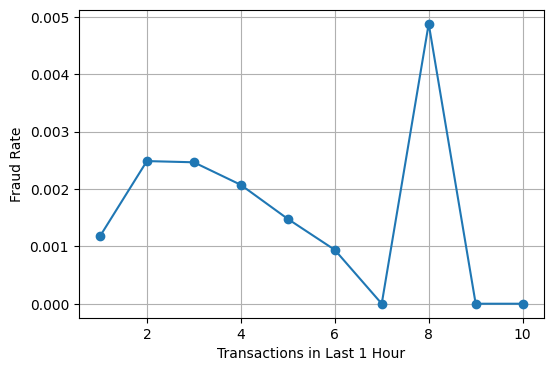

In [118]:
rate = (
    df.groupby("client_tx_1h")["fraud"]
      .mean()
)

plt.figure(figsize=(6,4))
rate.plot(marker="o")
plt.ylabel("Fraud Rate")
plt.xlabel("Transactions in Last 1 Hour")
plt.grid(True)
plt.show()

In [ ]:
# 1시간에 몇 건

df["tx_1h_bin"] = pd.cut(
    df["client_tx_1h"],
    bins=[0,1,2,3,5,10,50],
    right=False
)

pivot = df.pivot_table(
    index="tx_1h_bin",
    columns="has_error",
    values="fraud",
    aggfunc="mean"
)

pivot

/tmp/ipykernel_4093275/1208708879.py:8: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(


has_error,0,1
tx_1h_bin,,
"[1, 2)",0.001135,0.004639
"[2, 3)",0.002456,0.003329
"[3, 5)",0.002368,0.003173
"[5, 10)",0.001249,0.002299
"[10, 50)",0.000000,0.000000


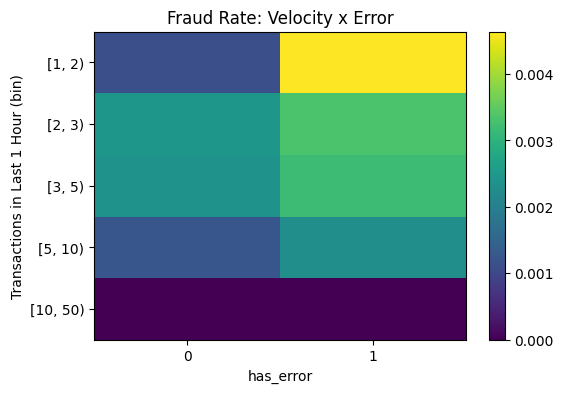

In [120]:
plt.figure(figsize=(6,4))
plt.imshow(pivot.values, aspect="auto")
plt.colorbar()
plt.xticks(range(len(pivot.columns)), pivot.columns)
plt.yticks(range(len(pivot.index)), pivot.index.astype(str))
plt.xlabel("has_error")
plt.ylabel("Transactions in Last 1 Hour (bin)")
plt.title("Fraud Rate: Velocity x Error")
plt.show()

In [122]:
cnt = df.pivot_table(index="tx_1h_bin", columns="has_error", values="fraud", aggfunc="size")
display(cnt)

/tmp/ipykernel_4093275/3253943802.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  cnt = df.pivot_table(index="tx_1h_bin", columns="has_error", values="fraud", aggfunc="size")


has_error,0,1
tx_1h_bin,,
"[0, 1)",0,0
"[1, 2)",4123532,45916
"[2, 3)",844395,28838
"[3, 5)",242416,8510
"[5, 10)",17608,1305
"[10, 50)",4,1


| tx_1h_bin | error=0  | error=1  |
| --------- | -------- | -------- |
| [1,2)     | 0.001135 | 0.004639 |
| [2,3)     | 0.002456 | 0.003329 |
| [3,5)     | 0.002368 | 0.003173 |
| [5,10)    | 0.001249 | 0.002299 |


> 최근 1시간 내 거래가 2~4건 발생한 구간에서 fraud rate가 가장 높게 관찰\
> 소규모 burst 패턴이 사기 세션의 특징\
> 모든 거래량 구간에서 error 발생 시 fraud rate가 추가적으로 증가\

비정상 시도 + 소규모 연속 거래

mcc_is_new × has_error × velocity

In [ ]:
df["spike_bin_simple"] = pd.cut(
    df["velocity_spike_ratio"],
    bins=[0,1,2,5,20],
    right=False
)
pivot = df.pivot_table(
    index="spike_bin_simple",
    columns=["client_mcc_is_new","has_error"],
    values="fraud",
    aggfunc="mean"
)

display(pivot.round(5))


/tmp/ipykernel_4093275/810311928.py:6: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(


client_mcc_is_new        0                 1         
has_error                0        1        0        1
spike_bin_simple                                     
[0, 1)             0.00104  0.00323  0.02155  0.06783
[1, 2)             0.00186  0.00250  0.07716  0.06579
[2, 5)             0.00190  0.00253  0.16667  0.50000

In [130]:
cnt = df.pivot_table(
    index="spike_bin_simple",
    columns=["client_mcc_is_new","has_error"],
    values="fraud",
    aggfunc="size"
)

display(cnt)

/tmp/ipykernel_4093275/3199240940.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  cnt = df.pivot_table(


has_error,0,1,0,1
spike_bin_simple,,,,
"[0, 1)",4898491,73887,77367,1032
"[1, 2)",242013,8783,1633,76
"[2, 5)",8433,790,18,2
"[5, 20)",0,0,0,0


> 표본 부족

velocity_spike_ratio =
client_tx_1h / client_avg_tx_1h_prev

In [ ]:
df = df.sort_values(["client_id", "date"]).reset_index(drop=True)


df["client_tx_1h_avg_prev"] = (
    df.groupby("client_id")["client_tx_1h"]
      .expanding()
      .mean()
      .shift(1)
      .reset_index(level=0, drop=True)
)

df["client_tx_1h_avg_prev"] = df["client_tx_1h_avg_prev"].fillna(0)


In [124]:
df["velocity_spike_ratio"] = (
    df["client_tx_1h"] /
    (df["client_tx_1h_avg_prev"] + 1)   # 안정성 위해 +1
)


In [125]:
df["velocity_spike_ratio"] = df["velocity_spike_ratio"].clip(upper=20)


In [126]:
df["spike_bin"] = pd.qcut(
    df["velocity_spike_ratio"],
    5,
    duplicates="drop"
)

rate = df.groupby("spike_bin")["fraud"].mean()
count = df.groupby("spike_bin")["fraud"].size()

display(rate)
display(count)


/tmp/ipykernel_4093275/1178372212.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate = df.groupby("spike_bin")["fraud"].mean()
/tmp/ipykernel_4093275/1178372212.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count = df.groupby("spike_bin")["fraud"].size()


spike_bin
(0.17, 0.438]     0.001156
(0.438, 0.449]    0.001084
(0.449, 0.459]    0.001139
(0.459, 0.74]     0.001294
(0.74, 3.955]     0.002563
Name: fraud, dtype: float64

spike_bin
(0.17, 0.438]     1062505
(0.438, 0.449]    1062522
(0.449, 0.459]    1062489
(0.459, 0.74]     1062504
(0.74, 3.955]     1062505
Name: fraud, dtype: int64

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5312525 entries, 0 to 5312524
Data columns (total 61 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   date                      datetime64[ns]
 1   client_id                 int64         
 2   card_id                   int64         
 3   amount                    float32       
 4   merchant_id               int64         
 5   mcc                       object        
 6   fraud                     int8          
 7   has_error                 int8          
 8   err_bad_card_number       int8          
 9   err_bad_expiration        int8          
 10  err_bad_cvv               int8          
 11  err_bad_pin               int8          
 12  err_bad_zipcode           int8          
 13  err_insufficient_balance  int8          
 14  err_technical_glitch      int8          
 15  tx_year                   int16         
 16  tx_month                  int8          
 17  tx_day  

In [134]:
column = ["client_tx_1h", "client_tx_1h_avg_prev", "velocity_spike_ratio"]
results = []

for col in column:

    X = sm.add_constant(df[[col]].dropna())
    y = df.loc[X.index, "fraud"]

    model = sm.Logit(y, X).fit(disp=0)

    coef = model.params[col]
    pval = model.pvalues[col]
    or_val = np.exp(coef)

    results.append([col, coef, or_val, pval])

pd.DataFrame(results, columns=["feature","coef","OR","p_value"])

,feature,coef,OR,p_value
0,client_tx_1h,0.339301,1.403966,2.515173e-144
1,client_tx_1h_avg_prev,-1.224995,0.293759,6.264485e-48
2,velocity_spike_ratio,1.001570,2.722553,9.815437e-218


In [135]:
X = sm.add_constant(df[col].dropna())
y = df["fraud"]

model = sm.Logit(y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.010834
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                  fraud   No. Observations:              5312525
Model:                          Logit   Df Residuals:                  5312523
Method:                           MLE   Df Model:                            1
Date:                Sun, 15 Feb 2026   Pseudo R-squ.:                0.006794
Time:                        15:42:18   Log-Likelihood:                -57554.
converged:                       True   LL-Null:                       -57948.
Covariance Type:            nonrobust   LLR p-value:                2.975e-173
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -7.1384      0.024   -301.744      0.000      -7.185      -7.09

| feature               | OR       | 의미                       |
| --------------------- | -------- | ------------------------ |
| client_tx_1h          | **1.40** | 1시간 거래 1건 증가 시 40% 위험 증가 |
| client_tx_1h_avg_prev | **0.29** | 평소 거래량이 높을수록 위험 ↓        |
| velocity_spike_ratio  | **2.72** | 평소 대비 1단위 증가 시 위험 2.7배   |

① 현재 거래량 많으면 위험 ↑

→ 공격 세션 burst 가능성

② 평소 거래량 많은 사람은 위험 ↓

→ 고활동 고객은 자연스럽게 거래 많음

③ 평소 대비 급증이 제일 강함

→ spike_ratio OR 2.72

---

# Interaction

**중복 수준 (0.8 이상)**

per_capita_income ↔ yearly_income (0.95)

current_age ↔ years_to_retirement (-0.91)

income_ratio_region ↔ log_income_ratio_region (0.90)

cb_Mastercard ↔ cb_Visa (-0.83)

expires_year ↔ months_to_expire (0.81)

log_yearly_income ↔ yearly_income (0.80)

error x fraud

In [37]:
# client/card 누적 fraud bin (현재행 제외 기준)
df["client_fraud_hist_bin"] = pd.cut(
    df["client_fraud_cum_prev"],
    bins=[-1, 0, 1, 2, np.inf],
    labels=["0", "1", "2", "3+"]
)

df["card_fraud_hist_bin"] = pd.cut(
    df["card_fraud_cum_prev"],
    bins=[-1, 0, 1, 2, np.inf],
    labels=["0", "1", "2", "3+"]
)

In [ ]:
def interaction_report(df, x, y, label="fraud", baseline_col=0, min_count=50):
    # (A) rate / count
    rate = df.pivot_table(index=x, columns=y, values=label, aggfunc="mean", observed=False)
    cnt  = df.pivot_table(index=x, columns=y, values=label, aggfunc="size", observed=False).fillna(0).astype(int)

    print(f"\n=== Interaction: {x} x {y} ===")
    print("Fraud rate:")
    display(rate.round(6))
    print("Count:")
    display(cnt)

    # (B) uplift (row-wise)
    if baseline_col in rate.columns:
        base = rate[baseline_col].replace(0, np.nan)
        uplift = rate.div(base, axis=0).round(2) 
        print(f"Uplift vs {y}={baseline_col} within each {x}:")
        display(uplift)

    # (C) Heatmap (optionally mask low-count cells)
    masked = rate.copy()
    masked[cnt < min_count] = np.nan  # 표본 너무 적은 칸은 해석 금지

    plt.figure(figsize=(6, 3.8))
    im = plt.imshow(masked.values, aspect="auto")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(masked.columns)), [str(c) for c in masked.columns])
    plt.yticks(range(len(masked.index)), [str(i) for i in masked.index])
    plt.xlabel(y)
    plt.ylabel(x)
    plt.title(f"Fraud rate heatmap: {x} x {y}")

    for i in range(masked.shape[0]):
        for j in range(masked.shape[1]):
            v = masked.values[i, j]
            if pd.notna(v):
                plt.text(j, i, f"{v:.4f}", ha="center", va="center")
            else:
                # low count 등으로 마스킹된 칸 표시
                if cnt.values[i, j] < min_count:
                    plt.text(j, i, f"n<{min_count}", ha="center", va="center", fontsize=8)

    plt.tight_layout()
    plt.show()


In [43]:
g = df.groupby("client_id")["has_error"]
df["client_error_last1"] = g.shift(1).fillna(0).astype("int8")

e1 = g.shift(1).fillna(0).astype("int8")
e2 = g.shift(2).fillna(0).astype("int8")
e3 = g.shift(3).fillna(0).astype("int8")
df["client_error_last3"] = (e1 + e2 + e3).astype("int8")


=== Interaction: client_fraud_hist_bin x has_error ===
Fraud rate:


has_error,0,1
client_fraud_hist_bin,,
0,0.000236,0.000473
1,0.008613,0.019119
2,0.012071,0.018788
3+,0.002852,0.008838


Count:


has_error,0,1
client_fraud_hist_bin,,
0,3278229,52907
1,84406,1726
2,57078,1650
3+,1808242,28287


Uplift vs has_error=0 within each client_fraud_hist_bin:


has_error,0,1
client_fraud_hist_bin,,
0,1.0,2.00
1,1.0,2.22
2,1.0,1.56
3+,1.0,3.10


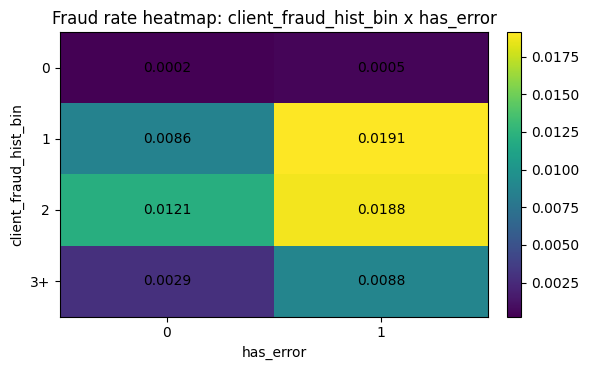


=== Interaction: client_fraud_hist_bin x client_error_last1 ===
Fraud rate:


client_error_last1,0,1
client_fraud_hist_bin,,
0,0.000243,0.000076
1,0.008719,0.014002
2,0.012247,0.012712
3+,0.002905,0.005512


Count:


client_error_last1,0,1
client_fraud_hist_bin,,
0,3278248,52888
1,84418,1714
2,57076,1652
3+,1808228,28301


Uplift vs client_error_last1=0 within each client_fraud_hist_bin:


client_error_last1,0,1
client_fraud_hist_bin,,
0,1.0,0.31
1,1.0,1.61
2,1.0,1.04
3+,1.0,1.90


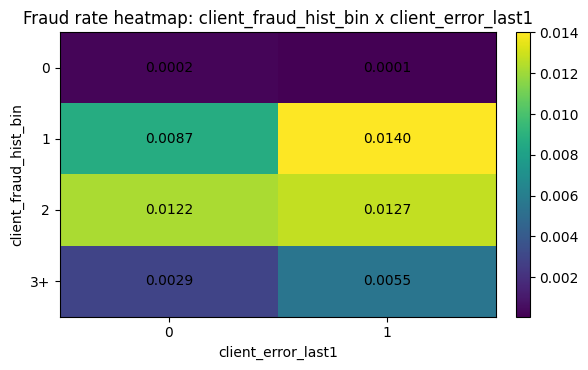


=== Interaction: client_fraud_hist_bin x client_error_last3 ===
Fraud rate:


client_error_last3,0,1,2,3
client_fraud_hist_bin,,,,
0,0.000243,0.000197,0.000000,0.0
1,0.008850,0.008528,0.006410,0.0
2,0.012181,0.014286,0.006073,0.0
3+,0.002830,0.005485,0.003180,0.0


Count:


client_error_last3,0,1,2,3
client_fraud_hist_bin,,,,
0,3178159,147418,5464,95
1,81356,4456,312,8
2,54348,3850,494,36
3+,1754531,79119,2830,49


Uplift vs client_error_last3=0 within each client_fraud_hist_bin:


client_error_last3,0,1,2,3
client_fraud_hist_bin,,,,
0,1.0,0.81,0.00,0.0
1,1.0,0.96,0.72,0.0
2,1.0,1.17,0.50,0.0
3+,1.0,1.94,1.12,0.0


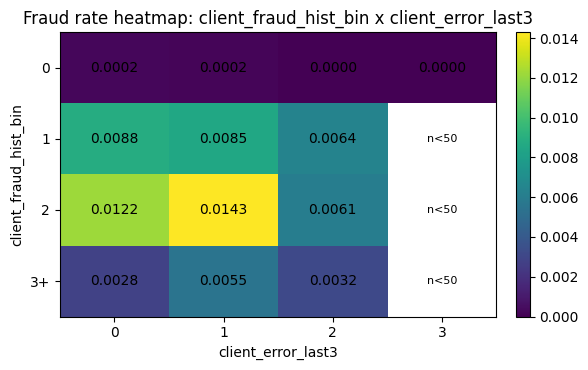

In [44]:
interaction_report(df, "client_fraud_hist_bin", "has_error")
interaction_report(df, "client_fraud_hist_bin", "client_error_last1")
interaction_report(df, "client_fraud_hist_bin", "client_error_last3")

**해석**:

history 0에서도 error 있으면 2배

history 1,2에서 error 있으면 거의 2~3배

특히 3+에서 uplift 3.10

**결론**:

error는 fraud history가 있을수록 증폭된다.

In [46]:
g = df.groupby("card_id")["has_error"]
df["card_error_last1"] = g.shift(1).fillna(0).astype("int8")

e1 = g.shift(1).fillna(0).astype("int8")
e2 = g.shift(2).fillna(0).astype("int8")
e3 = g.shift(3).fillna(0).astype("int8")
df["card_error_last3"] = (e1 + e2 + e3).astype("int8")


=== Interaction: card_fraud_hist_bin x has_error ===
Fraud rate:


has_error,0,1
card_fraud_hist_bin,,
0,0.000517,0.001224
1,0.012715,0.033113
2,0.021830,0.041184
3+,0.004583,0.014443


Count:


has_error,0,1
card_fraud_hist_bin,,
0,4346340,70248
1,63389,1359
2,31700,777
3+,786526,12186


Uplift vs has_error=0 within each card_fraud_hist_bin:


has_error,0,1
card_fraud_hist_bin,,
0,1.0,2.37
1,1.0,2.60
2,1.0,1.89
3+,1.0,3.15


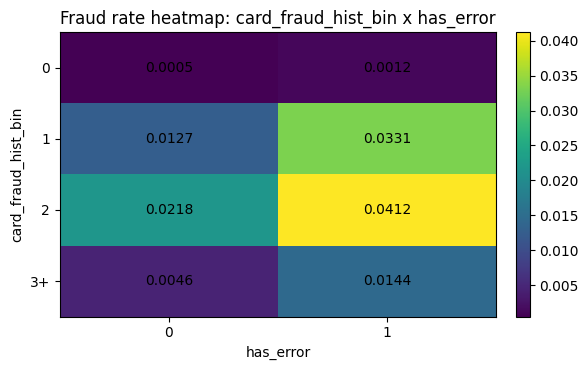


=== Interaction: card_fraud_hist_bin x card_error_last1 ===
Fraud rate:


card_error_last1,0,1
card_fraud_hist_bin,,
0,0.000523,0.000854
1,0.012974,0.021293
2,0.022085,0.030230
3+,0.004635,0.011159


Count:


card_error_last1,0,1
card_fraud_hist_bin,,
0,4346310,70278
1,63433,1315
2,31650,827
3+,786614,12098


Uplift vs card_error_last1=0 within each card_fraud_hist_bin:


card_error_last1,0,1
card_fraud_hist_bin,,
0,1.0,1.63
1,1.0,1.64
2,1.0,1.37
3+,1.0,2.41


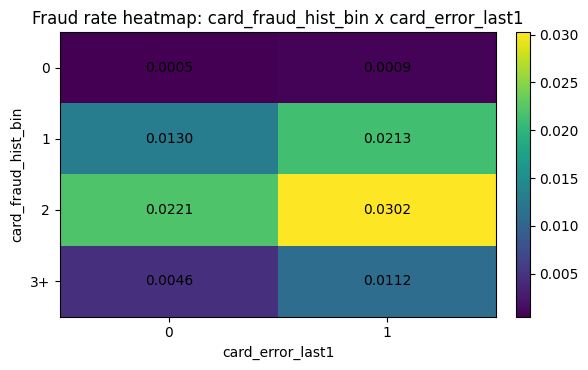


=== Interaction: card_fraud_hist_bin x card_error_last3 ===
Fraud rate:


card_error_last3,0,1,2,3
card_fraud_hist_bin,,,,
0,0.000511,0.000891,0.000292,0.0
1,0.013030,0.015447,0.009091,0.0
2,0.022104,0.026057,0.011976,0.0
3+,0.004428,0.011384,0.009540,0.0


Count:


card_error_last3,0,1,2,3
card_fraud_hist_bin,,,,
0,4213234,196364,6856,134
1,61092,3431,220,5
2,30266,2034,167,10
3+,763276,34259,1153,24


Uplift vs card_error_last3=0 within each card_fraud_hist_bin:


card_error_last3,0,1,2,3
card_fraud_hist_bin,,,,
0,1.0,1.74,0.57,0.0
1,1.0,1.19,0.70,0.0
2,1.0,1.18,0.54,0.0
3+,1.0,2.57,2.15,0.0


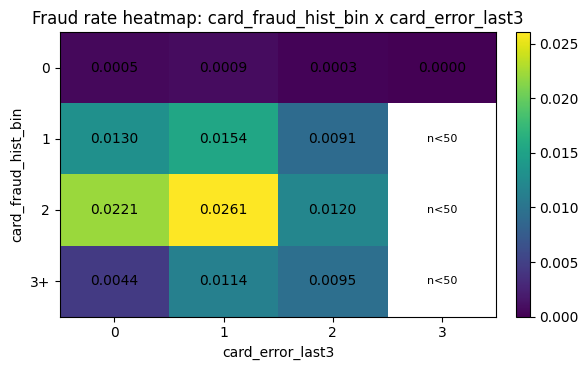

In [ ]:
interaction_report(df, "card_fraud_hist_bin", "has_error")
interaction_report(df, "card_fraud_hist_bin", "card_error_last1")
interaction_report(df, "card_fraud_hist_bin", "card_error_last3")

| hist | error=0 | error=1 |
| ---- | ------- | ------- |
| 1    | 0.0127  | 0.0331  |
| 2    | 0.0218  | 0.0412  |

card history 2 + error=1이면 4%대. => strong

baseline risk (fraud history)\
        +\
behavioral anomaly (error)\
        =\
explosive risk


In [49]:
df["client_hist_x_error"] = (
    df["client_has_fraud_history"] * df["has_error"]
)
df["card_hist_x_error"] = (
    df["card_has_fraud_history"] * df["card_error_last1"]
)

In [50]:
results = []

for col in ["client_hist_x_error",
            "card_hist_x_error"]:

    X = sm.add_constant(df[[col]].dropna())
    y = df.loc[X.index, "fraud"]

    model = sm.Logit(y, X).fit(disp=0)

    coef = model.params[col]
    pval = model.pvalues[col]
    or_val = np.exp(coef)

    results.append([col, coef, or_val, pval])

pd.DataFrame(results, columns=["feature","coef","OR","p_value"])



,feature,coef,OR,p_value
0,client_hist_x_error,1.968942,7.163096,1.822882e-253
1,card_hist_x_error,2.244741,9.437969,2.182594e-200


error x log_amount

In [ ]:
error_cols = [
    "err_bad_card_number",
    "err_bad_expiration",
    "err_bad_cvv",
    "err_bad_pin",
    "err_bad_zipcode",
    "err_insufficient_balance",
    "err_technical_glitch"
]

df["error_count"] = df[error_cols].sum(axis=1)

In [60]:
df["log_abs_amount"].describe()

count    5.312525e+06
mean     3.358956e+00
std      1.236704e+00
min      0.000000e+00
25%      2.552565e+00
50%      3.586570e+00
75%      4.278470e+00
max      8.647832e+00
Name: log_abs_amount, dtype: float64

In [ ]:
df.groupby("error_count")["log_abs_amount"].mean()

error_count
0    3.350889
1    3.856803
2    4.070040
3    4.142182
Name: log_abs_amount, dtype: float32

In [61]:
df.groupby(["error_count", "fraud"])["log_abs_amount"].mean().unstack()

fraud,0,1
error_count,,
0,3.349702,4.194403
1,3.855414,4.204591
2,4.058326,5.179854
3,4.142182,NaN


In [63]:
df["error_amount_interaction"] = (
    df["error_count"] * df["log_abs_amount"]
)

In [64]:
df["error_high_amount"] = (
    (df["error_count"] >= 2) &
    (df["high_amount"] == 1)
).astype("int8")


In [65]:
results = []

for col in ["error_amount_interaction",
            "error_high_amount"]:

    X = sm.add_constant(df[[col]].dropna())
    y = df.loc[X.index, "fraud"]

    model = sm.Logit(y, X).fit(disp=0)

    coef = model.params[col]
    pval = model.pvalues[col]
    or_val = np.exp(coef)

    results.append([col, coef, or_val, pval])

pd.DataFrame(results, columns=["feature","coef","OR","p_value"])

,feature,coef,OR,p_value
0,error_amount_interaction,0.268799,1.308392,6.688687e-98
1,error_high_amount,3.416196,30.453341,7.056094e-09


In [66]:
X = sm.add_constant(df[[
    "high_amount",
    "is_highrisk_mcc",
    "prepaid_logamount_interaction",
    "error_amount_interaction",
    "error_high_amount"
]].astype("float64"))

y = df["fraud"]

model = sm.Logit(y, X).fit()
print(model.summary())


Optimization terminated successfully.
         Current function value: 0.009969
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                  fraud   No. Observations:              5312525
Model:                          Logit   Df Residuals:                  5312519
Method:                           MLE   Df Model:                            5
Date:                Sun, 15 Feb 2026   Pseudo R-squ.:                 0.08610
Time:                        14:50:44   Log-Likelihood:                -52958.
converged:                       True   LL-Null:                       -57948.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -7.2015      0.017   -430.163      0